In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json 
import ast
from helpers import visualizing_data
import networkx as nx

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
dataframe = pd.read_csv('Data/movie.metadata.genres.tsv', sep='\t')



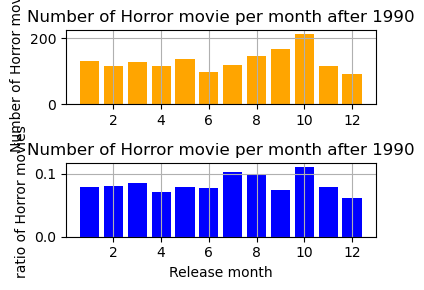

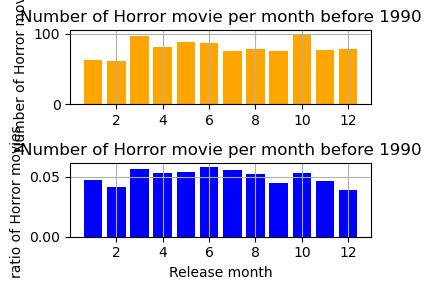

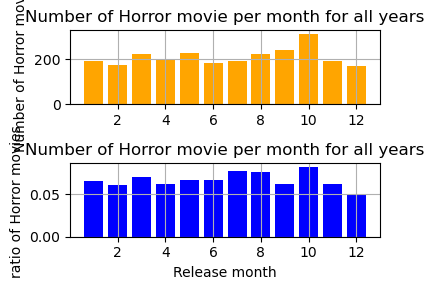

In [102]:
visualizing_data(dataframe, 1990, 'Horror') #input : df, split year, genre

Then, take the data after 1990 and remove the movies that aren't classified in any main genres

In [103]:
split_year = 1990
df3=dataframe[~(dataframe['genre 2'].isna() & dataframe['genre 1'].isna())] #removing when there 2 NaN : we lose around 4000 movies
df3_90= df3[df3['Movie release year']>=split_year]  #After 1990 42k -> 20k
df3_90=df3_90.reset_index(drop = True) #don't compute this over and over!!!!


Translate countries into json. Then obtain all the countries, remove countries with less than 5 movies and classify each country into a continent.

In [104]:
# enlever un warning
pd.options.mode.chained_assignment = None  # default='warn'

# Create an empty dataframe
empty_frame = pd.DataFrame(index=range(363),columns=range(2))
nb_countries = empty_frame.rename(columns={0: 'country', 1: 'nb of movies'})
nb_countries['nb of movies'].fillna(0,inplace=True)
i = 0

dfc5 = None
# Iterate over rows of df
for index, row in df3_90.iterrows():
    dfc2 = df3_90.iloc[index]['Movie countries']
    dfc3 = json.loads(dfc2)
    dfc4 = pd.json_normalize(dfc3)
    
    for column in dfc4:
        if not (nb_countries['country'].isin([dfc4[column].iloc[0]]).any()):
            nb_countries['country'].iloc[i] = dfc4[column].iloc[0]
            nb_countries['nb of movies'][i] = 1
            i = i+1
        else:
            idx = nb_countries.loc[nb_countries['country'].isin([dfc4[column].iloc[0]])].index
            nb_countries['nb of movies'][idx] = nb_countries['nb of movies'][idx] + 1


In [105]:
nb_countries=nb_countries[(nb_countries['nb of movies']>=5)] #remove countries with less than 5 movies (too long to classify them)
nb_countries = nb_countries.sort_values("nb of movies",ascending=False)
nb_countries = nb_countries.reset_index(drop = True) #don't compute this over and over!!!!
nb_countries.head()


,country,nb of movies
0,United States of America,9003
1,India,2485
2,United Kingdom,1783
3,France,1324
4,Canada,975


In [106]:
#Assign each country to its continent. Some exceptions : Australia in North America, culturally closer.
#EUROPE
searchfor_europe = ['France', 'Italy', 'United Kingdom', 'Slovak Republic', 'Russia', 'Germany', 'Spain', 'Netherlands', 'Sweden', 'Denmark', \
                    'Belgium', 'Ireland', 'Norway', 'Russia', 'Czech Republic', 'Finland', 'Switzerland', 'Portugal', 'Poland', 'Austria', \
                        'Hungary', 'England', 'Luxembourg', 'Romania', 'Iceland', 'Croatia', 'Greece', 'Serbia', 'Bulgaria', 'Slovakia', \
                            'Slovenia', 'Scotland', 'Estonia', 'Bosnia and Herzegovina', 'Lithuania', 'Soviet Union', 'Ukraine', 'Yugoslavia'\
                                'Czechoslovakia	', 'Albania	','Kingdom of Great Britain	', 'Serbia and Montenegro' ]
Europe = nb_countries[nb_countries['country'].str.contains('|'.join(searchfor_europe))]
Europe['continent'] = 'Europe'

#NORTH AMERICA
searchfor_northa = ['United States', 'Canada' , 'Mexico', 'Australia']
northa = nb_countries[nb_countries['country'].str.contains('|'.join(searchfor_northa))]
northa['continent'] = 'northa'

#SOUTH AMERICA
searchfor_southa = ['Brazil', 'Colombia' , 'Peru', 'Cuba', 'Puerto Rico', 'Venezuela', 'Uruguay', 'Jamaica', 'Argentina']
southa = nb_countries[nb_countries['country'].str.contains('|'.join(searchfor_southa))]
southa['continent'] = 'southa'

#ASIA
searchfor_Asia = ['China', 'Japan' , 'Nepal', 'South Korea', 'Singapore', 'Cambodia', 'Bangladesh', 'Vietnam', 'Lebanon', 'Burma', 'Sri Lanka',\
                   'Palestinian territories', 'Israel', 'Iraq', 'Republic of Macedonia', 'Korea', 'India', 'Hong Kong', 'Philippines', 'Turkey',\
                      'New Zealand', 'Thailand', 'Indonesia', 'Pakistan', 'Iran', 'Taiwan', 'Malaysia', 'United Arab Emirates', 'Afghanistan']
Asia = nb_countries[nb_countries['country'].str.contains('|'.join(searchfor_Asia))]
Asia['continent'] = 'Asia'

#AFRICA
searchfor_Africa = ['South Africa', 'Egypt', 'Morocco', 'Algeria', 'Kenya', 'Tunisia', 'Burkina Faso', 'Mali', 'Senegal', 'Democratic Republic of the Congo']
Africa = nb_countries[nb_countries['country'].str.contains('|'.join(searchfor_Africa))]
Africa['continent'] = 'Africa'


In [107]:
#Creating the main genre dataframe so we can modify the original frame
Continent =  pd.concat([Europe, northa, southa, Asia, Africa])
Continent = Continent.reset_index(drop = True)
Continent.head()

,country,nb of movies,continent
0,United Kingdom,1783,Europe
1,France,1324,Europe
2,Germany,956,Europe
3,Italy,359,Europe
4,Spain,323,Europe


Now, Create columns "continent_1" and "continent_2" in the dataframe with the assigned continents.

In [108]:
# Create empty column for 2 continents
df3_90['continent_1']= None
df3_90['continent_2'] = None


# Iterate over rows of df3_90
for index, row in df3_90.iterrows():
        df3_902 = df3_90.iloc[index]['Movie countries']
        df3_903 = json.loads(df3_902)
        df3_904 = pd.json_normalize(df3_903)

        for column in df3_904:
                boolarr = (Continent['country'].isin([df3_904[column].iloc[0]])) #array with of length len(country) with True for countries detected
                if (boolarr.sum() ==1):
                        continent_detected = Continent[boolarr]['continent'].values 
                        #if a country has 2 countries with different continents, assign them to 2 colums. ex : courage mountain : USA, France
                        if (df3_90['continent_1'].iloc[index] == None):
                                df3_90['continent_1'].iloc[index] = continent_detected
                        elif (df3_90['continent_2'].iloc[index] == None and df3_90['continent_1'].iloc[index]!= continent_detected):
                                df3_90['continent_2'].iloc[index] = continent_detected

df3_90.head()

,Unnamed: 0,Wikipedia movieID,Freebase movieID,Movie name,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie release year,Movie release month,genre 1,genre 2,continent_1,continent_2
0,21553,1179306,/m/04dx95,"White Hunter, Black Heart",2000000.0,112.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",1990,5,Action,Drama,[northa],None
1,21554,55495,/m/0ff4w,Miller's Crossing,5080409.0,115.0,"{""/m/03x42"": ""Irish"", ""/m/02bjrlw"": ""Italian L...","{""/m/09c7w0"": ""United States of America""}",1990,8,Thriller,Drama,[northa],None
2,21555,3831834,/m/0b28pv,The Freshman,21460601.0,103.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",1990,7,Thriller,Comedy,[northa],None
3,21556,29800724,/m/0fq298n,Pyar Ka Karz,NaN,130.0,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}",1990,3,Action,NaN,[Asia],None
4,21557,18149943,/m/04cx99m,Courage Mountain,1393610.0,100.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...",1990,2,Action,Family Film,[northa],[Europe]


In [109]:
df_continent = df3_90[['Movie name', 'Movie release year', 'genre 1', 'genre 2', 'Movie release month', 'continent_1', 'continent_2']]

'''
northa -> 1
Europe -> 2
southa -> 3
Asia -> 4
Africa -> 5
'''
print(df_continent["continent_2"].count()) #2143 pays ont dux contintents différents donc on considère que leur continent_1 fait l'affaire


df_continent['continent_1'] = df_continent['continent_1'].replace(['northa', 'Europe', 'southa', 'Asia', 'Africa'], [1, 2, 3, 4, 5])
df_continent

2143


,Movie name,Movie release year,genre 1,genre 2,Movie release month,continent_1,continent_2
0,"White Hunter, Black Heart",1990,Action,Drama,5,1.0,None
1,Miller's Crossing,1990,Thriller,Drama,8,1.0,None
2,The Freshman,1990,Thriller,Comedy,7,1.0,None
3,Pyar Ka Karz,1990,Action,NaN,3,4.0,None
4,Courage Mountain,1990,Action,Family Film,2,1.0,[Europe]
...,...,...,...,...,...,...,...
18883,Dirty Laundry,2012,Thriller,Action,7,1.0,None
18884,Seeking a Friend for the End of the World,2012,Romance,Drama,6,1.0,[Asia]
18885,El Gringo,2012,Action,NaN,5,1.0,None
18886,Romeo,2012,Romance,NaN,7,4.0,None


Preparing dataframe for analysis. Asign 1 for Horror movies and 0 for other genres. Keeping the features we want

In [110]:
df_analysis = df_continent.copy(deep=True)
df_analysis=df_analysis[~(df_analysis['continent_1'].isna())] #removing NaN continent

df_analysis['horror'] = (df_analysis['genre 1']=='Horror' )| (df_analysis['genre 2']=='Horror' )
df_analysis['horror'] = df_analysis['horror'].replace([True, False], [1, 0])
df_analysis=df_analysis[['horror','Movie release year', 'Movie release month', 'continent_1']]


df_analysis.rename(columns={"Movie release year": "Movie_release_year"}, inplace=True) #renaming because spaces are not convenient for causal analysis
df_analysis.rename(columns={"Movie release month": "Movie_release_month"}, inplace=True)

df_analysis.head()

,horror,Movie_release_year,Movie_release_month,continent_1
0,0,1990,5,1.0
1,0,1990,8,1.0
2,0,1990,7,1.0
3,0,1990,3,4.0
4,0,1990,2,1.0


Obtaining the propensity scores :

In [111]:
import statsmodels.formula.api as smf
# let's standardize the continuous features
df_analysis['Movie_release_year'] = (df_analysis['Movie_release_year'] - df_analysis['Movie_release_year'].mean())/df_analysis['Movie_release_year'].std()
df_analysis['continent_1'] = (df_analysis['continent_1'] - df_analysis['continent_1'].mean())/df_analysis['continent_1'].std()


mod = smf.logit(formula='horror ~  Movie_release_year + continent_1', data=df_analysis)

res = mod.fit()

# Extract the estimated propensity scores
df_analysis['Propensity_score'] = res.predict()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.284801
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 horror   No. Observations:                17592
Model:                          Logit   Df Residuals:                    17589
Method:                           MLE   Df Model:                            2
Date:                Thu, 16 Nov 2023   Pseudo R-squ.:                 0.01085
Time:                        11:38:07   Log-Likelihood:                -5010.2
converged:                       True   LL-Null:                       -5065.2
Covariance Type:            nonrobust   LLR p-value:                 1.347e-24
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -2.4279      0.028    -86.235      0.000      -2.483      -2.373
Movie

Then, we match the data, one treated with one control.
We first extract a random sample of the data for the analysis not to last too long but at the end we can take the whole data for accuracy

In [112]:
df_analysis_sample = df_analysis.sample(frac=0.1, random_state=1)# take 1/10 of the data


In [113]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [114]:
# Separate the treatment and control groups
treatment_df = df_analysis_sample[df_analysis_sample['horror'] == 1]
control_df = df_analysis_sample[df_analysis_sample['horror'] == 0]

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():

        # Calculate the similarity 
        similarity = get_similarity(control_row['Propensity_score'],
                                    treatment_row['Propensity_score'])

        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

In [115]:
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
balanced_df_1 = df_analysis.loc[matched]
balanced_df_1

,horror,Movie_release_year,Movie_release_month,continent_1,Propensity_score
10513,0,0.421349,8,1.608538,0.059554
16250,0,1.085228,11,-0.772129,0.117071
298,0,-2.234167,11,-0.772129,0.065342
18300,0,1.417168,10,-0.772129,0.123851
12571,0,0.753289,3,1.608538,0.063242
...,...,...,...,...,...
10051,1,0.421349,10,-0.772129,0.104473
14858,1,0.919258,2,-0.772129,0.113803
11706,1,0.587319,3,1.608538,0.061372
3388,1,-1.072378,10,-0.772129,0.080430


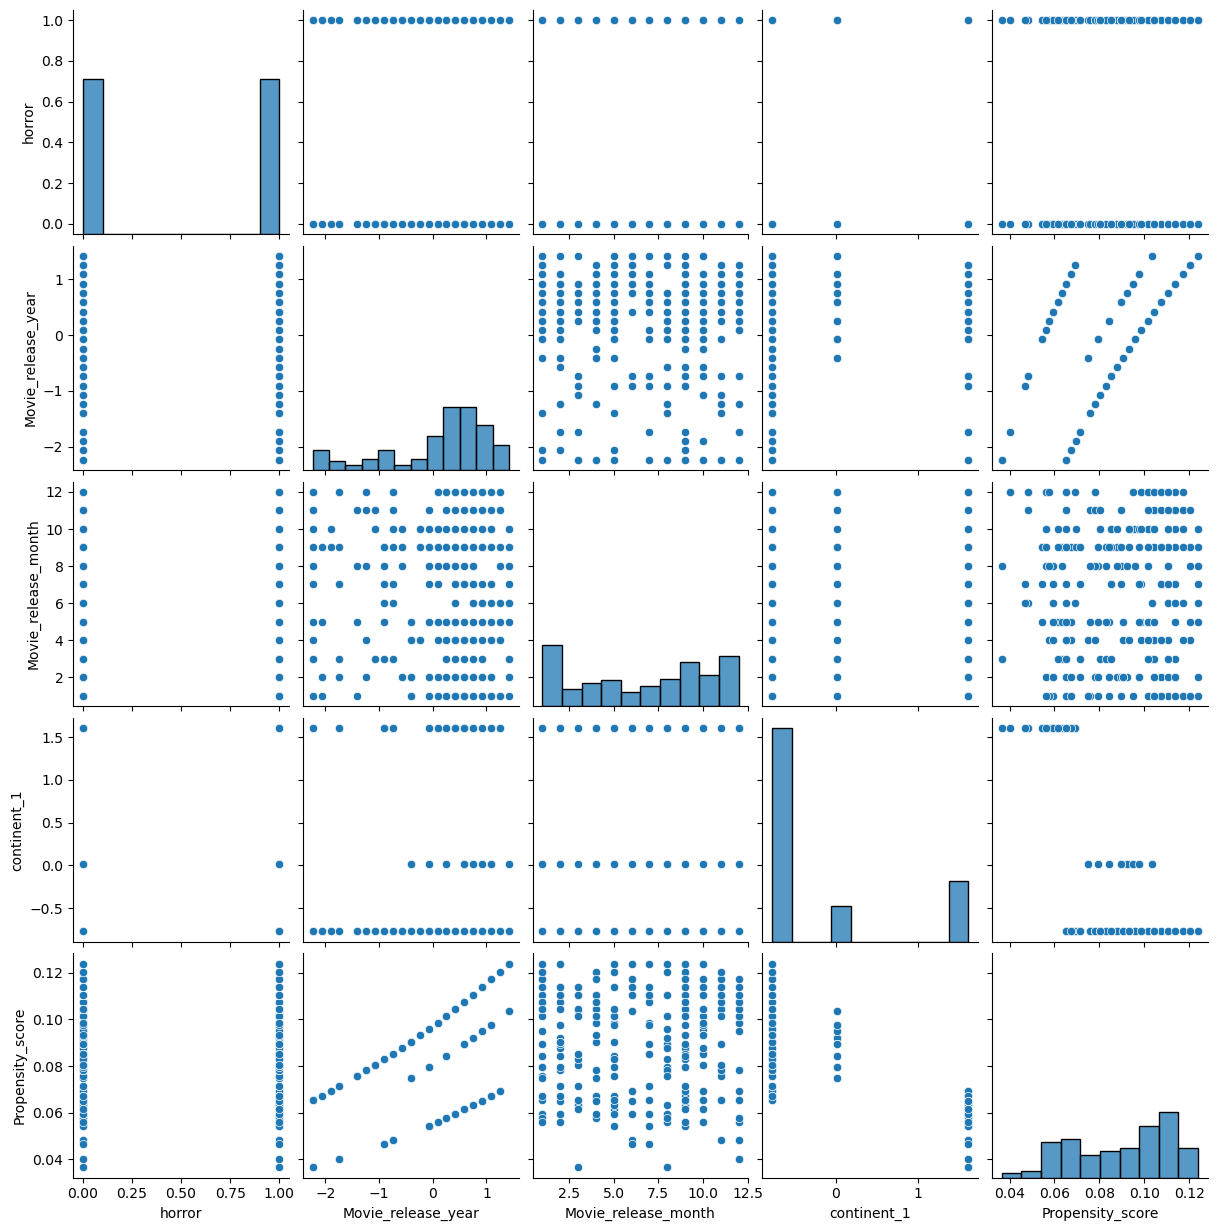

In [116]:
import seaborn as sns
sns.pairplot(balanced_df_1)

In [117]:
balanced_df_1.groupby('Movie_release_month').count()

,horror,Movie_release_year,continent_1,Propensity_score
Movie_release_month,,,,
1,28,28,28,28
2,26,26,26,26
3,15,15,15,15
4,20,20,20,20
5,23,23,23,23
6,12,12,12,12
7,18,18,18,18
8,24,24,24,24
9,39,39,39,39
